# Error mitigation

See [Qiskit tutorial](https://github.com/Qiskit/qiskit-iqx-tutorials/blob/1748699b49c44003c0e7505d0cd2249df25b973a/qiskit/advanced/ignis/4_measurement_error_mitigation.ipynb) for more details.

In [1]:
from qiskit import *

# Matplotlib is recommended for Qiskit. Others are for fun.
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
%matplotlib inline

# Load account (requires a saved IBMQ user id) and list backends with OpenPulse support.
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [2]:
# Notebook widget for watching IBMQ jobs.
import qiskit.tools.jupyter
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

ibmqx2


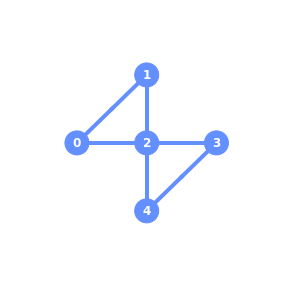

In [3]:
# Set least busy device as backend.
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_gate_map, plot_circuit_layout

small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                   and not x.configuration().simulator)
backend = least_busy(small_devices)

# Set qasm as simulator.
simulator = Aer.get_backend('qasm_simulator')

# Print name and configuration of backend.
from qiskit.visualization import plot_gate_map
print(backend)
plot_gate_map(backend)

## Calibration matrix for three qubits

The function `complete_meas_cal` returns a list of calibrations for a given set of qubits.

In [10]:
qr = QuantumRegister(5)
qubit_list = [0, 1, 2]

# Generate calibrations for specified qubits.
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
meas_cals, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')
print(state_labels)

['000', '001', '010', '011', '100', '101', '110', '111']


In [11]:
# Run calibrations on backend. 
job = execute(meas_cals, backend, optimization_level=0, shots=5000)
print(job.job_id())
result = job.result()

5e4b58ed5f4c4900115c8e48


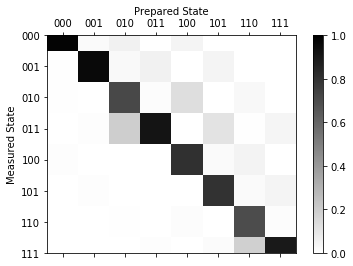

F(av)= 0.847425
F(q0)= 0.941425


In [18]:
# Calibration matrix: prepared state vs. measured state.
meas_fit = CompleteMeasFitter(result, state_labels, circlabel='mcal')
meas_fit.plot_calibration()

# Compute fidelities.
print('F(av)= ' + str(meas_fit.readout_fidelity()))
print('F(q0)= ' + str(meas_fit.readout_fidelity(label_list=[['000','001','010','011'],
                                                            ['100','101','110','111']])))

## Correcting measurement noise for GHZ state

In [20]:
qr = qr
cr = ClassicalRegister(3)

# GHZ state preparation circuit w/ measurement.
ghz = QuantumCircuit(qr, cr)
ghz.h(0)
ghz.cx(0, 1)
ghz.cx(1, 2)
ghz.measure(range(3), range(3))

print(ghz)

         ┌───┐          ┌─┐      
q3_0: |0>┤ H ├──■───────┤M├──────
         └───┘┌─┴─┐     └╥┘┌─┐   
q3_1: |0>─────┤ X ├──■───╫─┤M├───
              └───┘┌─┴─┐ ║ └╥┘┌─┐
q3_2: |0>──────────┤ X ├─╫──╫─┤M├
                   └───┘ ║  ║ └╥┘
q3_3: |0>────────────────╫──╫──╫─
                         ║  ║  ║ 
q3_4: |0>────────────────╫──╫──╫─
                         ║  ║  ║ 
 c5_0: 0 ════════════════╩══╬══╬═
                            ║  ║ 
 c5_1: 0 ═══════════════════╩══╬═
                               ║ 
 c5_2: 0 ══════════════════════╩═
                                 


In [21]:
# Prepare and measure GHZ on backend.
job = execute(ghz, backend, shots=5000)
print(job.job_id())
result = job.result()

5e4b5b967f49c800112dee84


In [26]:
# Counts without calibration.
counts = result.get_counts()

# Filter from calibration.
meas_filter = meas_fit.filter

# Mitigated results.
miti_result = meas_filter.apply(result)
miti_counts = miti_result.get_counts(0)

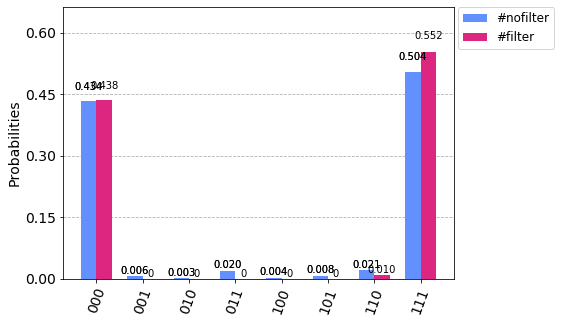

In [27]:
# Plot counts vs mitigated counts.
from qiskit.visualization import plot_histogram
plot_histogram([counts, miti_counts], legend=['#nofilter', '#filter'])